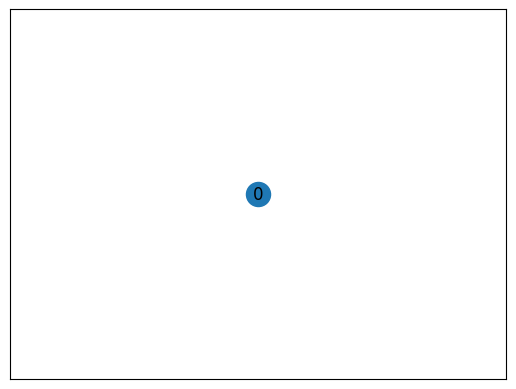

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import torch as th

from graph_produce.helpers import generate_random_dag, generate_random_distributions

n = 1

adjacency_matrix = generate_random_dag(n, 0.2)

state_init_matrix = th.zeros(n, 4)


G = nx.from_numpy_matrix(adjacency_matrix, create_using=nx.DiGraph)

pos = nx.spring_layout(G)  # Positions for all nodes

nx.draw_networkx(G, pos, with_labels=True, arrows=True)
plt.show()

In [5]:
dists = [[th.distributions.Uniform(9, 11), th.distributions.Uniform(9, 11), th.distributions.Uniform(9, 11)]] #generate_random_distributions(n, 3, 50, 1, distribution_types=['uniform'])

state_init_matrix[:, 1] = 1

buffer_size_limit = th.randint(1, 10, (n,))
buffer_size_limit[-1] = 1e10

In [6]:
from graph_produce.prod_graph import ProdGraph

graph = ProdGraph(adjacency_matrix, dists, buffer_size_limit, batch_size=40)

prev_time = 0
for i in range(1000):
    graph.forward()
    print(graph.features)

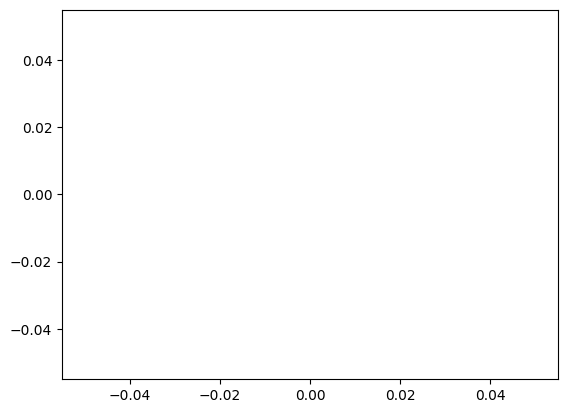

In [7]:
plt.plot(graph.log[:, 0], graph.log[:, 1])
plt.show()

In [4]:
last_buffer = graph.log[graph.log['node'] == graph.log['node'].max()]

import matplotlib.pyplot as plt

plt.plot(last_buffer['time'], last_buffer['output_buffer'] / last_buffer['time'])
plt.show()

TypeError: 'NoneType' object is not subscriptable

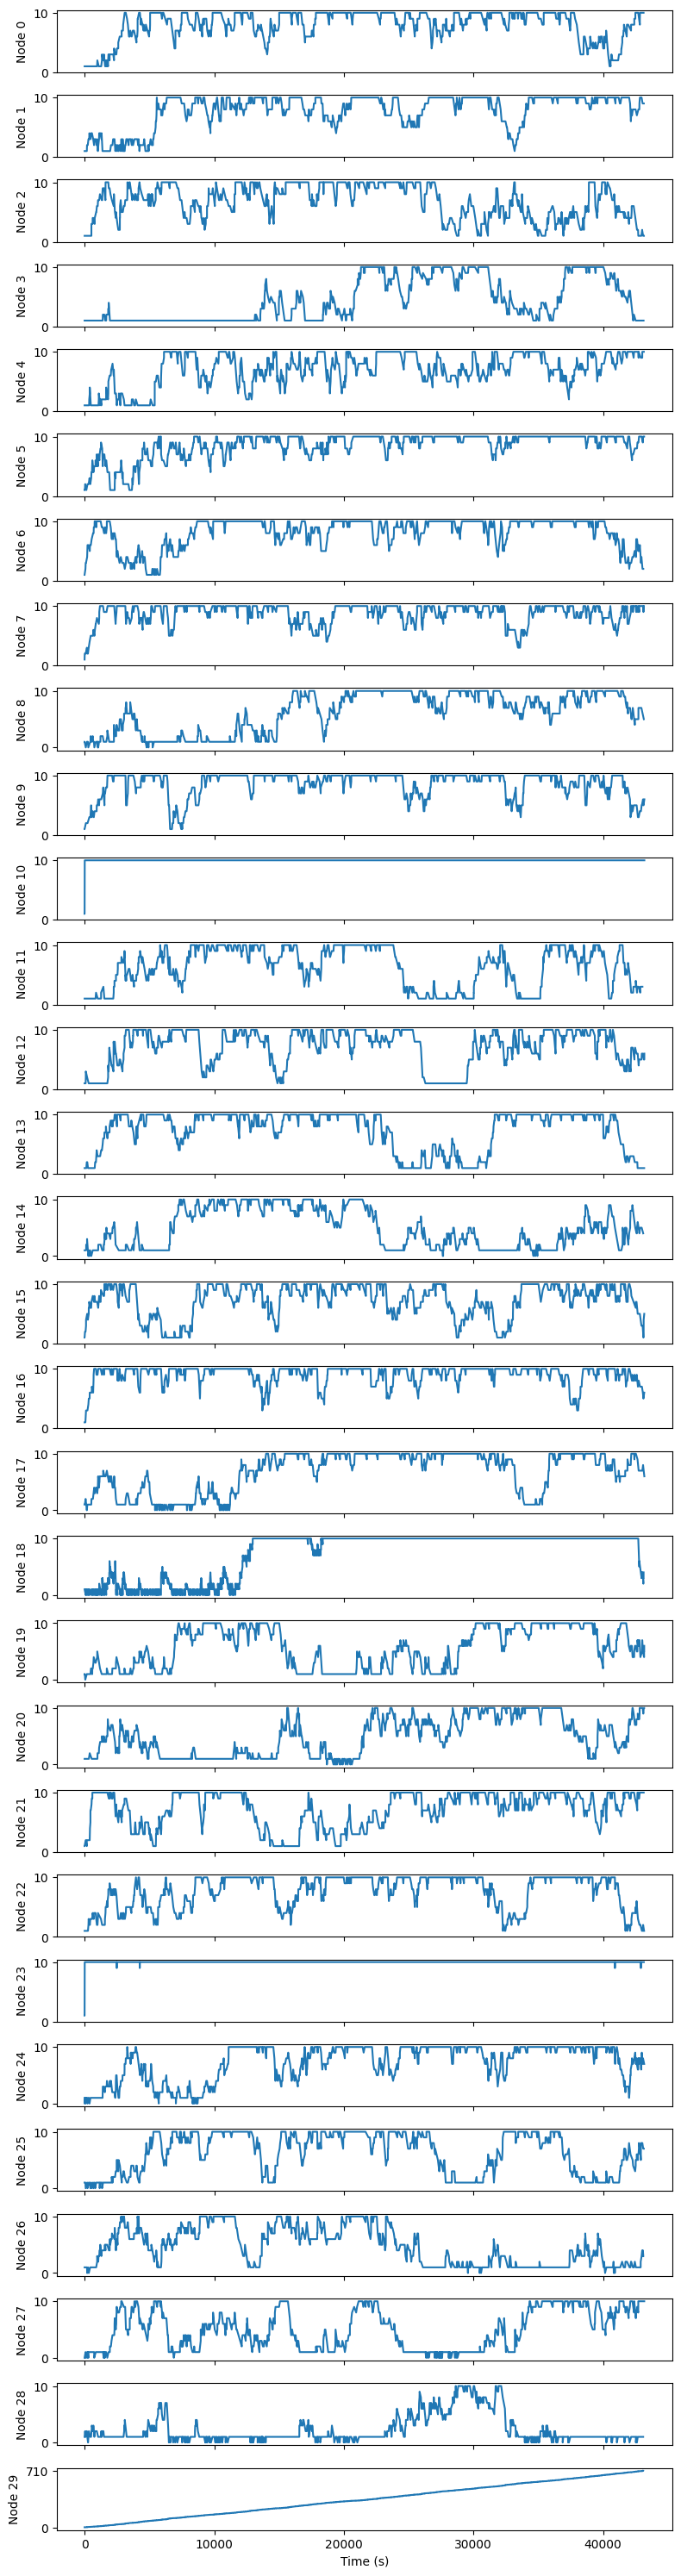

In [ ]:
from graph_produce.visual import plot_time_series_color, plot_time_series_producing

plot_time_series_producing(graph, 30)

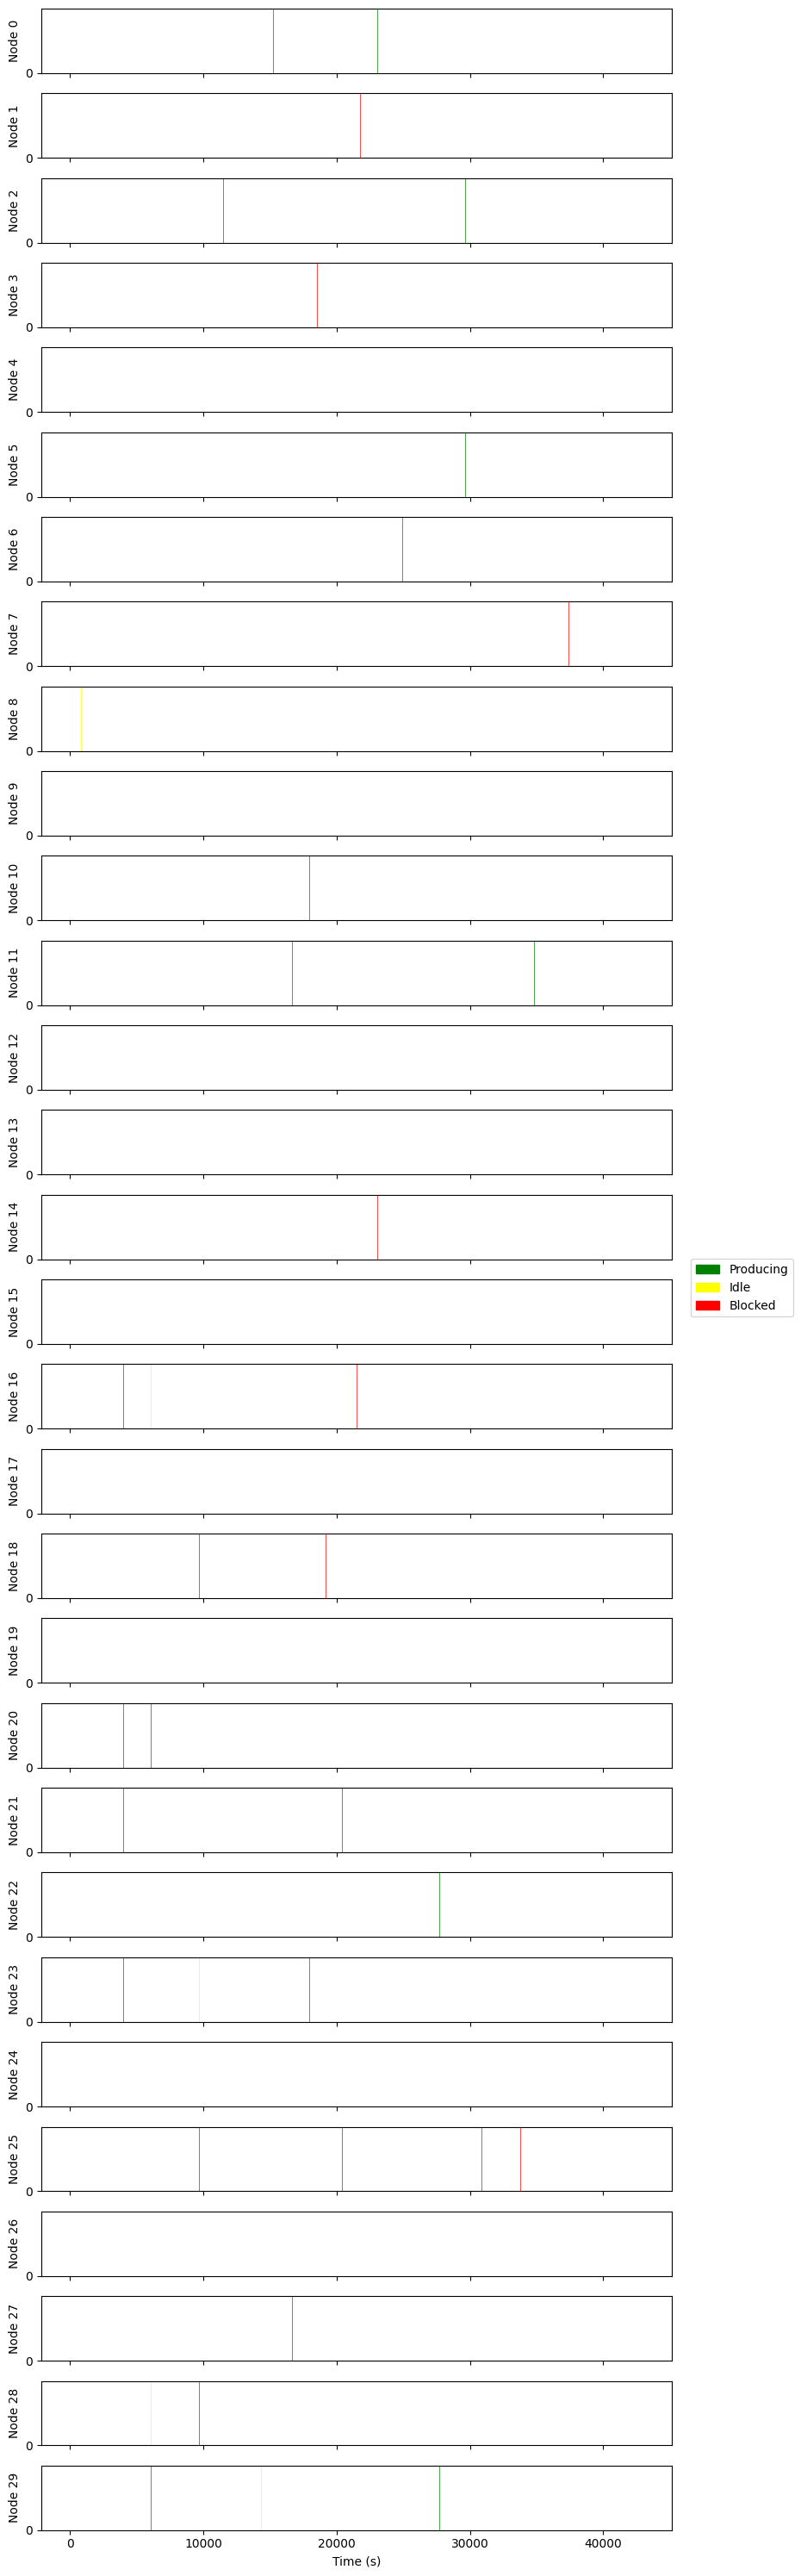

In [ ]:
plot_time_series_color(graph, 30)